# Solving 3-D Magneto-Coriolis Eigenproblems

Reproducing the results from [Waves in the Earth's core II. Magneto-Coriolis modes](https://doi.org/10.1098/rspa.2022.0108).

The initial import in Jupyter notebook seems to be slightly laggy. This is probably due to loading of the quicc package or just-in-time compilation?

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import models
from operators import polynomials as poly
import utils, pgpy_utils, tools

## Toroidal quadrupolar field

*T1* field in the paper. 

$$
\mathbf{B}_0 = \nabla \times \left(\gamma r(1 - r^2) Y_1^0(\theta, \phi) \mathbf{r}\right) = \gamma r(1 - r^2) \sin\theta \hat{\phi}
$$

In [3]:
E_eta = 1e-4
Elsasser = 1.
m_val = 1
bg_modes = [poly.SphericalHarmonicMode("tor", 1, 0, "(3 Sqrt[3]/2) r(1 - r^2)")]
mod_setup_MC = models.MagnetoCoriolis

Compute eigenvalue spectrum

In [71]:
tools.print_heading(f"Calculating eigen spectrum for m = {m_val}, E_eta = {E_eta:.2e}, Elsasser = {Elsasser: .2e}", 
                    prefix='\n', suffix='\n', lines="over", char='=')

resolutions = [
    (31, 31, m_val),
    (41, 41, m_val)
]
# spectra = list()
spectra_QP = list()
spectra_DP = list()

for i_res, res in enumerate(resolutions):
    
    nr, maxnl, m = res
    tools.print_heading(f"Resolution (L, N)=({maxnl}, {nr})", prefix='\n', suffix='\n', lines="over", char='-')
    
    with utils.Timer("Build operator"):
        
        mod = mod_setup_MC(
            nr, maxnl, m, inviscid=True,
            induction_eq_params={'galerkin': True, 'ideal': False, 'boundary_condition': True}
        )
        # A, B = mod.setup_operator(
        #     field_modes=bg_modes, setup_eigen=True, magnetic_ekman=E_eta, elsasser=Elsasser
        # )
        op_dp, op_qp = mod.setup_operator(
            field_modes=bg_modes, setup_eigen=True, magnetic_ekman=E_eta, elsasser=Elsasser, 
            parity=True, u_parity="same"
        )
    
    # print(f"K shape: {A.shape[0]}x{A.shape[1]}\n"
    #       f"M shape: {B.shape[0]}x{B.shape[1]}")  
    # with utils.Timer("Solve eigensystem"):
    #     w = utils.full_spectrum(A, B)
    # spectra.append(w)
    # del A, B
    
    print(f"DP system: {op_dp[0].shape[0]}x{op_dp[0].shape[1]}")
    with utils.Timer("Solve DP eigensystem"):
        w = utils.full_spectrum(op_dp[0], op_dp[1])
    spectra_DP.append(w)
    
    print(f"QP system: {op_qp[0].shape[0]}x{op_qp[0].shape[1]}")
    with utils.Timer("Solve DP eigensystem"):
        w = utils.full_spectrum(op_qp[0], op_qp[1])
    spectra_QP.append(w)


Calculating eigen spectrum for m = 1, E_eta = 1.00e-04, Elsasser =  1.00e+00


----------------------------------------------------------------
Resolution (L, N)=(31, 31)

Build operator elapsed 3.31 s.
DP system: 1830x1830
Solve DP eigensystem elapsed 98.01 s.
QP system: 1830x1830
Solve DP eigensystem elapsed 92.88 s.

----------------------------------------------------------------
Resolution (L, N)=(41, 41)

Build operator elapsed 7.53 s.
DP system: 3240x3240
Solve DP eigensystem elapsed 426.41 s.
QP system: 3240x3240
Solve DP eigensystem elapsed 420.93 s.


Sort according to their imaginary parts:

In [8]:
for i_w, w in enumerate(spectra):
    sort_idx = np.argsort(np.imag(w))
    spectra[i_w] = w[sort_idx]

### Inspect spectrum

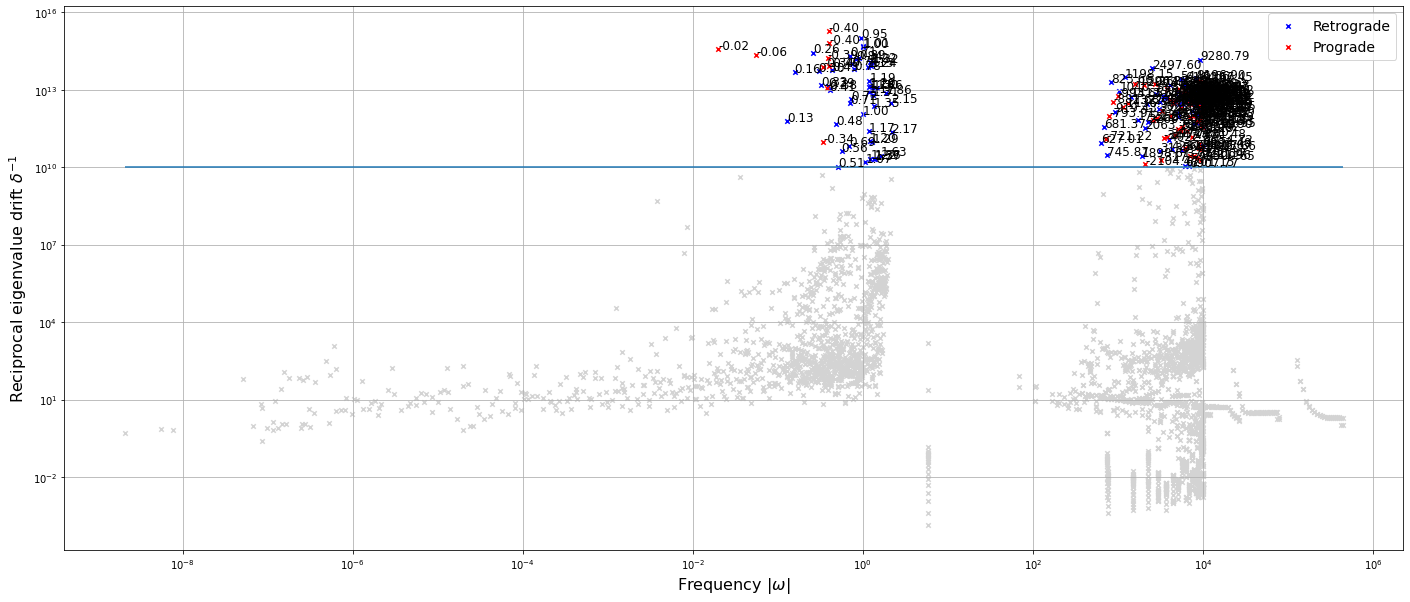

In [81]:
eig_base, eig_comp = spectra_DP[1], spectra_DP[0]
drift, nearest_idx = pgpy_utils.eigen_drift(eig_base, eig_comp)

fig, ax = plt.subplots(figsize=(24, 10))

threshold = 1e+10
reciproc = 1./drift
idx = np.arange(drift.size)

# ax.scatter(idx[reciproc > threshold], reciproc[reciproc > threshold], 20, color='b', marker='x')
# ax.scatter(idx[reciproc <= threshold], reciproc[reciproc <= threshold], 20, color='k', marker='x')
# for idx_tmp in idx[reciproc > threshold]:
#     ax.annotate("{:.2f}".format(eig_vals[1][idx_tmp]), (idx_tmp, reciproc[idx_tmp]))
# ax.hlines([threshold,], idx[0] - 1, idx[-1] + 1)
# ax.set_xlim([idx[0] - 1, idx[-1] + 1])

idx_pos = eig_base.imag >= 0
idx_neg = eig_base.imag < 0

ax.scatter(np.abs(eig_base[(reciproc > threshold) & idx_pos].imag), reciproc[(reciproc > threshold) & idx_pos], 20, color='b', marker='x', label="Retrograde")
ax.scatter(np.abs(eig_base[(reciproc > threshold) & idx_neg].imag), reciproc[(reciproc > threshold) & idx_neg], 20, color='r', marker='x', label="Prograde")
ax.scatter(np.abs(eig_base[reciproc <= threshold].imag), reciproc[reciproc <= threshold], 20, color='lightgray', marker='x')
for idx_tmp in idx[reciproc > threshold]:
    ax.annotate("{:.2f}".format(eig_base[idx_tmp].imag), (np.abs(eig_base[idx_tmp].imag), reciproc[idx_tmp]), fontsize=12)
ax.hlines([threshold,], np.abs(eig_base.imag).min(), np.abs(eig_base.imag).max())
ax.legend(fontsize=14)

ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim([np.abs(eig_base.imag).min(), np.abs(eig_base.imag).max()])
# ax.set_xlim([10, np.abs(eig_base.imag).max()])
ax.set_xlabel(r"Frequency $|\omega|$", fontsize=16)
ax.set_ylabel(r"Reciprocal eigenvalue drift $\delta^{-1}$", fontsize=16)
ax.grid(which="both")

plt.show()

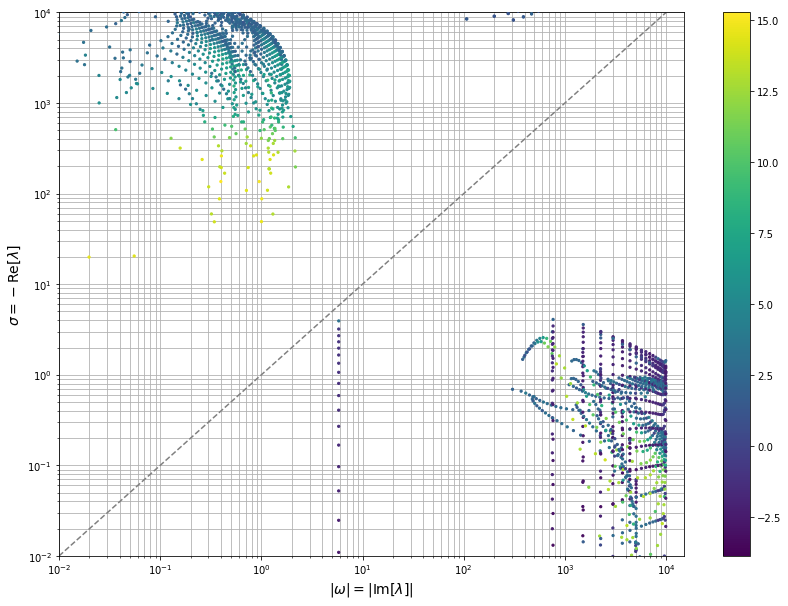

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 10))

im = ax.scatter(np.abs(np.imag(eig_base)), -np.real(eig_base), s=5, c=np.log10(reciproc), zorder=5)
plt.colorbar(im, ax=ax)

ax.plot([1e-2, 1e+4], [1e-2, 1e+4], '--', color="gray")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-2, 1.5e+4])
ax.set_ylim([1e-2, 1e+4])
ax.set_xlabel(r"$|\omega| = |\mathrm{Im}[\lambda]|$", fontsize=14)
ax.set_ylabel(r"$\sigma = -\mathrm{Re}[\lambda]$", fontsize=14)
ax.grid(which="both")

plt.show()

Output

In [14]:
import h5py

with h5py.File("./out/T1__eigenspec_m1__E_eta_1e-4.h5", 'x') as fwrite:
    for i_res, res in enumerate(resolutions):
        gp = fwrite.create_group(f"eigenspec_res{i_res}")
        gp.attrs["L"] = res[0]
        gp.attrs["N"] = res[1]
        gp.attrs["m"] = res[2]
        gp.create_dataset("spectrum", data=spectra[i_res])

In [80]:
import h5py

with h5py.File("./out/T1__eigenspec_m1__E_eta_1e-4__same_parities.h5", 'x') as fwrite:
    for i_res, res in enumerate(resolutions):
        gp = fwrite.create_group(f"eigenspec_res{i_res}")
        gp.attrs["L"] = res[0]
        gp.attrs["N"] = res[1]
        gp.attrs["m"] = res[2]
        ds = gp.create_dataset("spectrum_DP", data=spectra_DP[i_res])
        ds.attrs["u_parity"] = "same"
        ds = gp.create_dataset("spectrum_QP", data=spectra_QP[i_res])
        ds.attrs["u_parity"] = "same"

Filtering

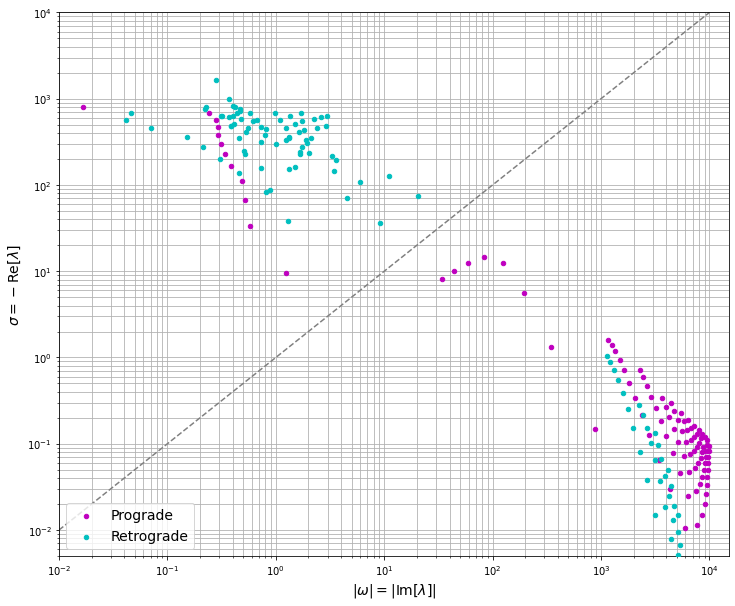

In [79]:
threshold = 1e+8
converge_filter = reciproc > threshold

spectrum_converged = eig_base[converge_filter]

classify_list = [
    [lambda x: x.imag < -1e-7, {"s": 20, "marker": 'o', "color": "m", "label": "Prograde"}],
    [lambda x: x.imag > +1e-7, {"s": 20, "marker": 'o', "color": "c", "label": "Retrograde"}]
]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))

for classifier in classify_list:
    class_idx = classifier[0](spectrum_converged)
    ax.scatter(np.abs(np.imag(spectrum_converged[class_idx])), -np.real(spectrum_converged[class_idx]), **classifier[1], zorder=5)

ax.plot([1e-2, 1e+4], [1e-2, 1e+4], '--', color="gray")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-2, 1.5e+4])
ax.set_ylim([0.5e-2, 1e+4])
ax.set_xlabel(r"$|\omega| = |\mathrm{Im}[\lambda]|$", fontsize=14)
ax.set_ylabel(r"$\sigma = -\mathrm{Re}[\lambda]$", fontsize=14)
ax.grid(which="both")
ax.legend(fontsize=14, loc=3)

plt.show()